In [1]:
import os
import pickle as pk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from helper_utils.utils import *

In [2]:
# Load data

data_directory = "processed_data"
data_filename_base = "X_top300_201701_201912_30_m_final"
data_filename_ext = ".npz"
data_filename = data_filename_base+data_filename_ext

data = {}
with np.load(os.path.join(data_directory, data_filename)) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        data[key] = npz_loader[key]

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]


input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(y_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape

X_train: (26593, 300, 10, 4)
y_train: (26593, 300, 10, 2)
X_val: (5318, 300, 10, 4)
y_val: (5318, 300, 10, 2)
X_test: (10637, 300, 10, 4)
y_test: (10637, 300, 10, 2)


In [3]:
from models.fnn import FNN
from models.linear import LinearRegressor
from models.fclstm import FCLSTM
from models.stgcn import STGCN
from models.wavenet import GraphWaveNet

In [4]:
model_params = {  'num_layers': 2,
                  'units_per_layer':256,
                  'num_nodes': num_nodes,
                  'num_steps': num_steps,
                  'input_features': input_features,
                  'output_features': output_features,
                  'l2_reg': 0.00}

training_specs = {'model_name': 'FNN',
                  'save_model': True,
                  'save_model_history': True,
                  'model_path': '',
                  'history_path': ''}

BATCH_SIZE = 64
MAX_EPOCHS = 20
PATIENCE = 5
LOSS_TYPE = "mae"
LEARNING_RATE = 1e-3

callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

In [5]:
tf.__version__

'2.8.0'

In [6]:
model = FNN(model_params)

model.compile(loss=LOSS_TYPE, optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
print(model(X_train[:32]).shape)
model.summary()

(32, 300, 10, 2)
Model: "fnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  10496     
                                                                 
 dense_1 (Dense)             multiple                  65792     
                                                                 
 dense_2 (Dense)             multiple                  5140      
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
Total params: 81,428
Trainable params: 81,428
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x=X_train, y=y_train, shuffle=True,
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    validation_data=(X_val,y_val),
                    callbacks=[callback_es])

Epoch 1/20
416/416 [==============================] - 79s 186ms/step - loss: 0.9601 - val_loss: 1.1724
Epoch 2/20
416/416 [==============================] - 75s 180ms/step - loss: 0.9157 - val_loss: 1.1589
Epoch 3/20
416/416 [==============================] - 76s 184ms/step - loss: 0.9069 - val_loss: 1.1533
Epoch 4/20
416/416 [==============================] - 78s 187ms/step - loss: 0.9022 - val_loss: 1.1488
Epoch 5/20
416/416 [==============================] - 76s 182ms/step - loss: 0.8992 - val_loss: 1.1467
Epoch 6/20
416/416 [==============================] - 75s 181ms/step - loss: 0.8969 - val_loss: 1.1410
Epoch 7/20
416/416 [==============================] - 76s 182ms/step - loss: 0.8944 - val_loss: 1.1501
Epoch 8/20
416/416 [==============================] - 77s 186ms/step - loss: 0.8940 - val_loss: 1.1398
Epoch 9/20
416/416 [==============================] - 76s 183ms/step - loss: 0.8916 - val_loss: 1.1384
Epoch 10/20
416/416 [==============================] - 76s 182ms/step - l

333/333 [==============================] - 12s 36ms/step - loss: 0.8583
FNN test Loss =  0.8582643270492554


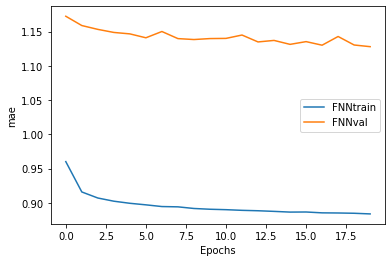

In [8]:
# EVALUATION
plt.figure()
plt.xlabel("Epochs")
plt.ylabel(LOSS_TYPE)
plt.plot(history.history['loss'],label=training_specs['model_name']+'train')
plt.plot(history.history['val_loss'],label=training_specs['model_name']+'val')
plt.legend()

print(training_specs['model_name']+" test Loss = ", model.evaluate(X_test,y_test))

In [9]:
predictions = model.predict(X_test)
predictions = seq_from_windows(predictions, horizon=0)
ground_truth = seq_from_windows(y_test, horizon=0)

In [10]:
model_store_directory = "stored_models"
run_info_store_directory = "stored_models"

if training_specs['save_model']:
    model_store_filename = "_".join([training_specs['model_name'], "model"])
    model_store_filepath = os.path.join(model_store_directory, model_store_filename)
    model.save(model_store_filepath, save_format="tf")

if training_specs['save_model_history']:
    run_info = {}
    run_info["history"] = history.history
    run_info["predictions"] = predictions
    run_info["ground_truth"] = ground_truth

    run_info_store_filename = "_".join([training_specs['model_name'], "run_info"]) + ".pk"
    run_info_store_filepath = os.path.join(run_info_store_directory, run_info_store_filename)
    pk.dump(run_info, open(run_info_store_filepath, "wb"))

INFO:tensorflow:Assets written to: stored_models\FNN_model\assets


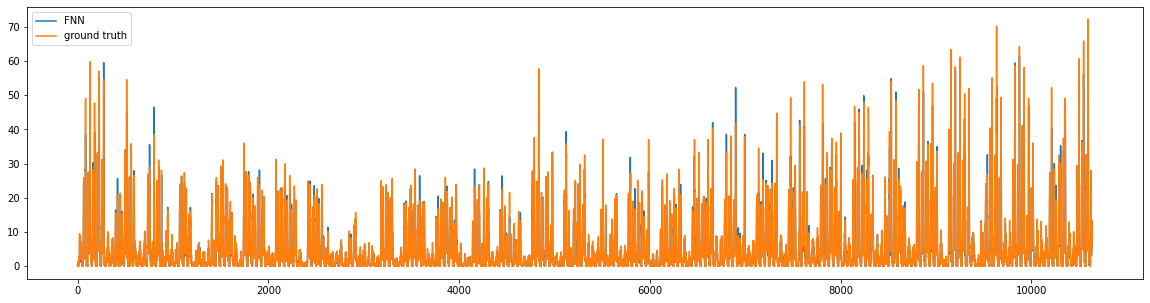

In [11]:
station = 0

plt.figure(figsize=(20,5))
plt.plot(predictions[station,:,0],label=training_specs['model_name'])
plt.plot(ground_truth[station,:,0],label='ground truth')
plt.legend()